This file is for analyzing a neighbourhood, to predict potential flooding hotspots due to high urban density.

# Importing base libraries

In [94]:
import geopandas as gpd
import pandas as pd

In [95]:
import urllib.request

In [96]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# User should change the link for the GeoJson Files here
 GeoJson files for buildings and Highways could be downloaded from Overpass Turbo here: https://overpass-turbo.eu/

In [97]:
# Load your GeoJSON data into a GeoDataFrame
road_data = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/Thesis/tardeo road.geojson")


building_data = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/Thesis/tardeo building.geojson')

#Streets representation

##Workflow for plotting streets with street widths as line weights

In [98]:
# Convert GeoDataFrame to DataFrame to ensure it includes all attributes
street_data = pd.DataFrame(road_data)

In [99]:
# Print the first few rows of the DataFrame
print(street_data.head())

              id            @id access addr:postcode alt_name alt_name:en  \
0   way/38718961   way/38718961   None          None     None        None   
1   way/39108422   way/39108422   None          None     None        None   
2   way/39165242   way/39165242   None          None     None        None   
3   way/56198129   way/56198129   None          None     None        None   
4  way/208118846  way/208118846   None          None     None        None   

  alt_name:etymology:wikidata      amenity  area bicycle  ... source:bridge  \
0                        None  fuel; kiosk   yes    None  ...          None   
1                        None         None   yes    None  ...          None   
2                        None  fuel; kiosk  None    None  ...          None   
3                        None         None   yes    None  ...          None   
4                        None         None   yes    None  ...          None   

  step_count surface trail_visibility tunnel vehicle width wik

In [100]:
street_data.head()

,id,@id,access,addr:postcode,alt_name,alt_name:en,alt_name:etymology:wikidata,amenity,area,bicycle,...,source:bridge,step_count,surface,trail_visibility,tunnel,vehicle,width,wikidata,wikipedia,geometry
0,way/38718961,way/38718961,None,None,None,None,None,fuel; kiosk,yes,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((72.80371 18.96539, 72.80368 18.96569..."
1,way/39108422,way/39108422,None,None,None,None,None,None,yes,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((72.80620 18.95751, 72.80615 18.95738..."
2,way/39165242,way/39165242,None,None,None,None,None,fuel; kiosk,None,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((72.80579 18.96441, 72.80554 18.96447..."
3,way/56198129,way/56198129,None,None,None,None,None,None,yes,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((72.81776 18.95369, 72.81780 18.95376..."
4,way/208118846,way/208118846,None,None,None,None,None,None,yes,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((72.82344 18.93380, 72.82349 18.93379..."


Avergae Widths

In [101]:
column_names = road_data.columns
for column_name in column_names:
    print(column_name)

id
@id
access
addr:postcode
alt_name
alt_name:en
alt_name:etymology:wikidata
amenity
area
bicycle
bridge
check_date
construction
covered
crossing
crossing:markings
cutting
cycleway
description
divider
embankment
fixme
foot
footway
handrail
highway
highway_1
horse
imagery_used
incline
junction
lane_markings
lanes
layer
level
lit
maxspeed
motor_vehicle
motorcar
motorcycle
mtb:scale
name
name:en
name:etymology:wikidata
name:hi
name:mr
name:ur
name_1
new_name
noname
note
old_name
oneway
opening_date
operator
parking:lane:both
postal_code
private
ramp
sac_scale
service
sidewalk
smoothness
source
source:bridge
step_count
surface
trail_visibility
tunnel
vehicle
width
wikidata
wikipedia
geometry


In [102]:
unique_values = road_data['lanes'].unique()

# Print the unique values
print(unique_values)

[None '2' '4' '3' '1']


In [103]:
# Get the count of each unique value in the 'lanes' column
value_counts = road_data['lanes'].value_counts()

# Print the unique values and their counts
print(value_counts)


lanes
2    57
3    47
4    25
1    14
Name: count, dtype: int64


In [104]:
# Get the most frequent value in the 'lanes' column
most_frequent_value = road_data['lanes'].value_counts().idxmax()

# Replace None or NaN values with the most frequent value
road_data['lanes'].fillna(most_frequent_value, inplace=True)

# Print the result to check
print(road_data['lanes'])


0       2
1       2
2       2
3       2
4       2
       ..
4230    2
4231    2
4232    2
4233    2
4234    2
Name: lanes, Length: 4235, dtype: object


In [105]:
# Get the count of each unique value in the 'lanes' column
value_counts = road_data['lanes'].value_counts()

# Print the unique values and their counts
print(value_counts)

lanes
2    4149
3      47
4      25
1      14
Name: count, dtype: int64


##Plotting the street network

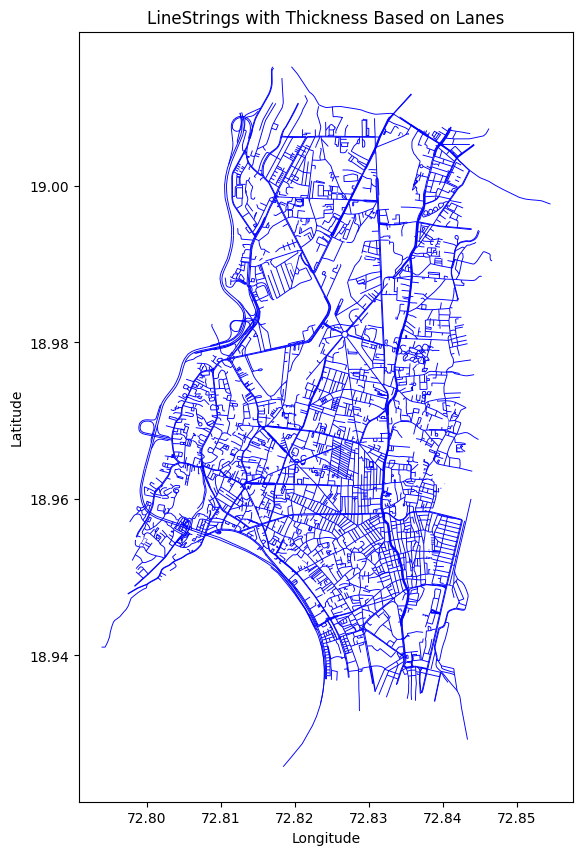

In [106]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Ensure 'lanes' column is numeric for multiplication
road_data['lanes'] = pd.to_numeric(road_data['lanes'], errors='coerce')

# Calculate the thickness by multiplying the number of lanes by 1.2
road_data['thickness'] = road_data['lanes'] /3

# Plot the lines with varying thickness
fig, ax = plt.subplots(figsize=(10, 10))

# Plot each LineString with corresponding thickness
road_data.plot(ax=ax, linewidth=road_data['thickness'], color='blue')

# Add title and labels
plt.title('LineStrings with Thickness Based on Lanes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show plot
plt.show()


# Building representation

##Users should change the GeoJSON link for the buildings here

In [107]:
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np
from shapely.geometry import Point

# Reset the index if needed
building_data = building_data.reset_index(drop=True)

# Check and ensure that the geometries are polygons
if not all(building_data.geometry.type == 'Polygon'):
    print("Warning: Some geometries are not polygons!")

# Remove rows with Point geometries
building_data = building_data[~building_data['geometry'].apply(lambda geom: isinstance(geom, Point))]

# Reproject to a suitable projected CRS (e.g., UTM zone for Mumbai, EPSG:32643)
building_data = building_data.to_crs(epsg=32643)  # UTM zone 43N, adjust based on your location

# Calculate centroids of the polygons
building_data['centroid'] = building_data['geometry'].centroid

# Extract the centroids as an array of coordinates
centroid_coords = np.array([[point.x, point.y] for point in building_data['centroid']])

# Compute pairwise distances between centroids
distances = euclidean_distances(centroid_coords)




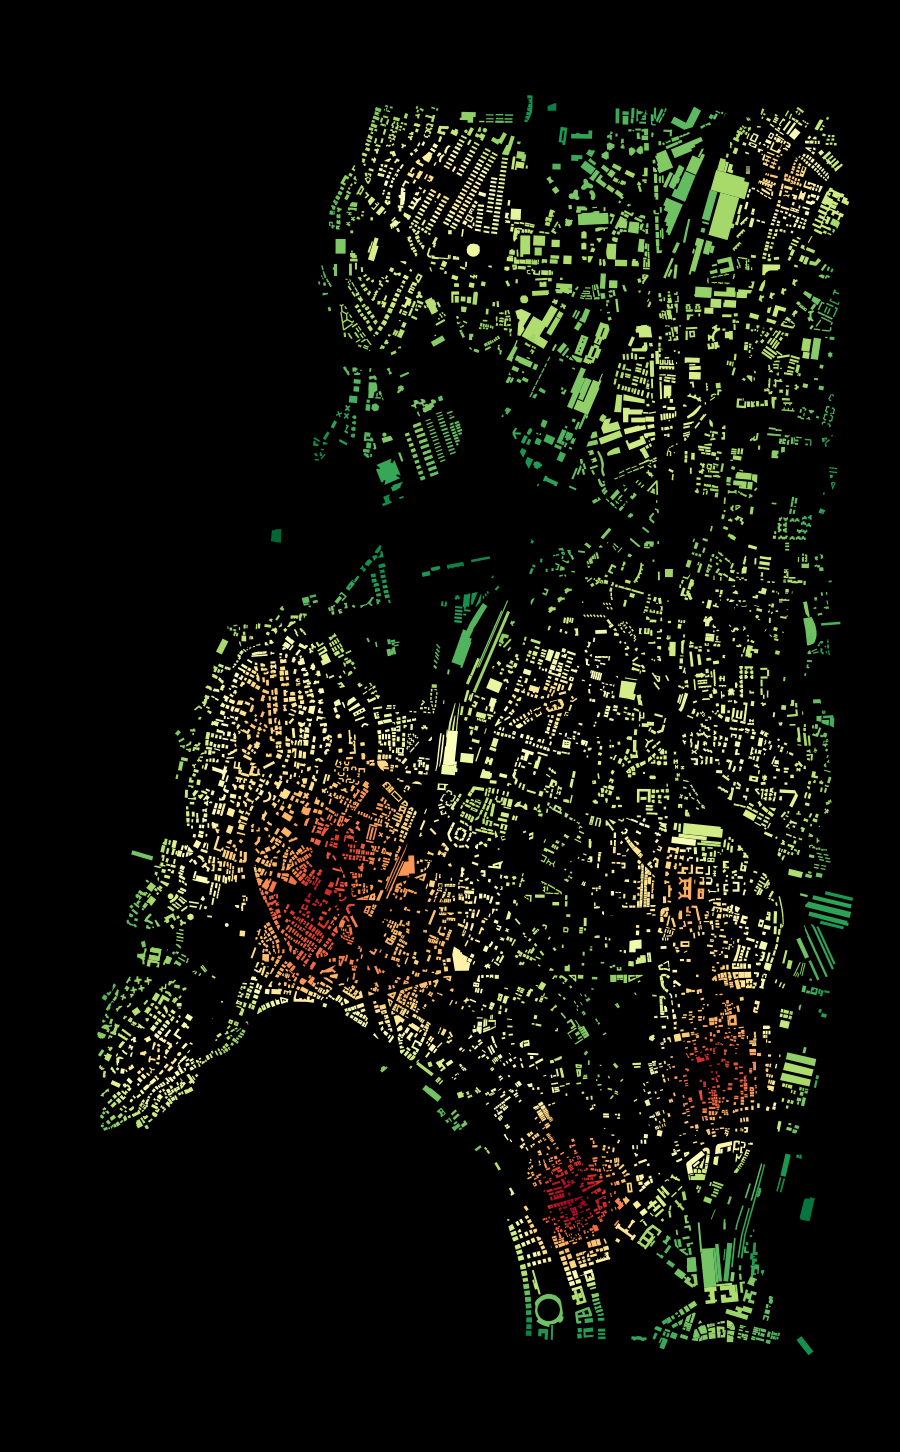

In [108]:
# Define a distance threshold for counting nearby buildings
threshold_distance = 400  # Adjust this value based on your data and scale

# Calculate density: count the number of neighbors within the threshold distance
density = np.sum(distances < threshold_distance, axis=1) - 1  # Subtract 1 to exclude self

# Normalize the density for color mapping
building_data['density'] = density
building_data['norm_density'] = (building_data['density'] - building_data['density'].min()) / (building_data['density'].max() - building_data['density'].min())

# Define the RGB color for the background (e.g., light gray)
background_rgb = (0,0, 0)  # Change this to your desired RGB color

# Plot the buildings with a color scale from green to red based on density
fig, ax = plt.subplots(1, 1, figsize=(20, 18))

# Set the background color to the specified RGB color
fig.patch.set_facecolor(background_rgb)

# Plot polygons with color based on 'norm_density'
building_data.plot(column='norm_density', cmap='RdYlGn_r', linewidth=0.8, ax=ax)

# Set the background color for the plot itself
ax.set_facecolor(background_rgb)

# Add title and show the plot
plt.title('Building Density Heatmap')
plt.show()



In [109]:
building_data

,id,@id,access,addr:city,addr:country,addr:district,addr:full,addr:housename,addr:housenumber,addr:place,...,url,website,wheelchair,wikidata,wikimedia_commons,wikipedia,geometry,centroid,density,norm_density
0,relation/4246877,relation/4246877,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,"POLYGON ((270084.230 2099021.554, 270081.516 2...",POINT (270101.700 2099001.458),164,0.498462
1,relation/5270708,relation/5270708,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,"POLYGON ((270429.962 2098552.557, 270395.808 2...",POINT (270415.426 2098491.414),167,0.507692
2,relation/5270709,relation/5270709,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,"POLYGON ((270546.078 2098647.244, 270539.165 2...",POINT (270563.697 2098630.403),112,0.338462
3,relation/5270710,relation/5270710,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,"POLYGON ((269838.582 2097311.511, 269826.449 2...",POINT (269844.907 2097293.821),158,0.480000
4,relation/5270711,relation/5270711,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,"POLYGON ((269812.651 2097327.423, 269800.725 2...",POINT (269817.945 2097310.832),155,0.470769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7012,way/1289154799,way/1289154799,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,"POLYGON ((272651.754 2098228.284, 272646.791 2...",POINT (272669.278 2098213.171),83,0.249231
7013,way/1300028268,way/1300028268,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,"POLYGON ((271932.029 2098026.160, 271931.619 2...",POINT (271965.856 2097985.140),219,0.667692
7014,way/356208148,way/356208148,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,"POLYGON ((268603.731 2097656.337, 268612.919 2...",POINT (268633.634 2097681.178),93,0.280000
7015,way/356208156,way/356208156,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,"POLYGON ((268581.018 2097676.695, 268594.824 2...",POINT (268555.671 2097719.954),91,0.273846


#Ensuring both plots are on same crs

In [110]:
import matplotlib.pyplot as plt

In [111]:
print(building_data.crs)
print(road_data.crs)#street data


EPSG:32643
EPSG:4326


In [112]:
street_data = road_data.to_crs(building_data.crs)

In [113]:
print("Updated Building Data CRS:", building_data.crs)
print("Updated Street Data CRS:", street_data.crs)

Updated Building Data CRS: EPSG:32643
Updated Street Data CRS: EPSG:32643


#plot

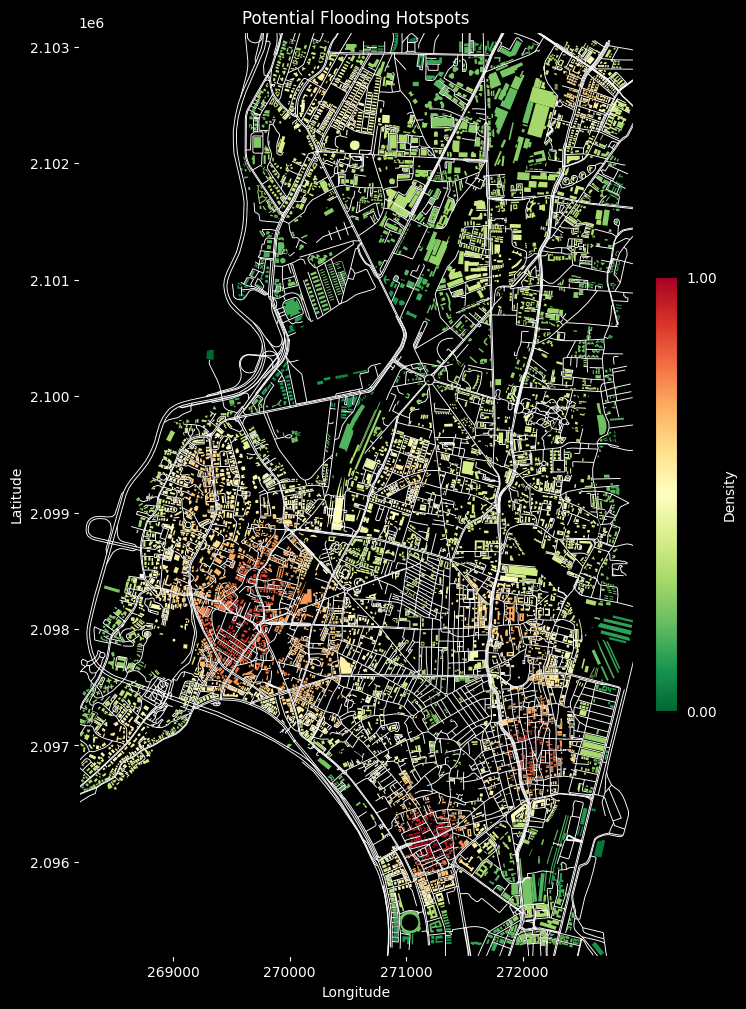

In [114]:
# Check if both GeoDataFrames have the same CRS, and if not, convert gdf to match building_data's CRS
if building_data.crs != road_data.crs:
    gdf = road_data.to_crs(building_data.crs)

# Define the RGB color for the background (e.g., black)
background_rgb = (0, 0, 0)

# Set up the figure and axis for plotting
fig, ax = plt.subplots(1, 1, figsize=(14,12))

# Set background color for the figure and the plot area
fig.patch.set_facecolor(background_rgb)
ax.set_facecolor(background_rgb)

# --------------------
# First plot: Buildings with density heatmap
# Normalize the density for color mapping
building_data['norm_density'] = (building_data['density'] - building_data['density'].min()) / (building_data['density'].max() - building_data['density'].min())

# Plot the buildings with color scale based on 'norm_density'
building_data.plot(column='norm_density', cmap='RdYlGn_r', linewidth=0.8, ax=ax)

# Set the axis limits to match the extent of building_data (bounding box)
ax.set_xlim([building_data.total_bounds[0], building_data.total_bounds[2]])  # Set x-axis limits
ax.set_ylim([building_data.total_bounds[1], building_data.total_bounds[3]])  # Set y-axis limits

# --------------------
# Second plot: LineStrings with varying thickness
# Plot LineStrings with corresponding thickness (add them to the same axis)
gdf.plot(ax=ax, linewidth=gdf['thickness'], color='white')

# Add a colorbar (legend) for the gradient
norm = plt.Normalize(vmin=building_data['norm_density'].min(), vmax=building_data['norm_density'].max())
sm = plt.cm.ScalarMappable(cmap='RdYlGn_r', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.02)

cbar.set_label('Density', color='white')

# Add start and end values to the colorbar
cbar_ticks = [norm.vmin, norm.vmax]
cbar.set_ticks(cbar_ticks)
cbar.set_ticklabels([f'{x:.2f}' for x in cbar_ticks])

# Set color for the colorbar tick labels
cbar.ax.tick_params(labelcolor='white')

# Add title and labels
plt.title('Potential Flooding Hotspots', color='white')
plt.xlabel('Longitude', color='white')
plt.ylabel('Latitude', color='white')

# Set axis label colors and ticks to white for better visibility on a black background
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Show the plot
plt.show()


For understanding different level of seriousness the values of the threshold can be tweaked for getting exact spots